In [1]:
# using Pkg/
# Pkg.activate(".")

In [2]:
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


In [3]:
#mu - gravitational parameter (m3/s2)
mu = 3.986e14

3.986e14

In [4]:
#radius of Earth (m)
r_e = 6.371e6

6.371e6

In [5]:
#sma from ppt
a = 6.85635e6

6.85635e6

In [6]:
#constant mean motion of target n = sqrt(mu/a^3)
#units: rad/s
n = sqrt(mu/a^3)

0.0011120624547982091

In [7]:
#number of states
nx = 6

#number of control inputs
nu = 3

3

In [8]:
#this is a whole orbit for dt=60
N = 94

#this is a whole orbit for dt=5650

#N = 5650

94

In [9]:
#target orbit period in seconds
T = 2*pi*sqrt((a^3)/(mu))

5650.029168838104

In [10]:
#timestep 
#dt = 60

dt = 1

1

In [11]:
thist = LinRange(1, N*dt, N)

94-element LinRange{Float64, Int64}:
 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, …, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0

In [12]:
x0_target = zeros(nx) 

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [13]:
#using the true data from the ppt
#this is in eci frame
# x0_chaser = [-0.2913181949406862,
#              -259.0113696278884,
#              1986.134383662354,
#              -2.2156282462577286,
#              4.171718001089175e-5,
#              -0.0003198930062353611]

In [14]:
#this is in RTN frame

x0_chaser = [ -0.2913181949406862
              2002.9519913273894
              2.7017514072632172e-14
              0.002412819262479271
              -1.5962127995240716e-12
              3.511794450825904e-14]

6-element Vector{Float64}:
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [15]:
A = zeros(nx, nx)
A[1:3, 4:6] = I(3)
A[4, 1] = 3*n^2
A[6, 3] = -n^2
A[4, 5] = 2*n
A[5, 4] = -2*n

-0.0022241249095964182

In [16]:
#mass of the satellite (kg) from data
m = 5.22

5.22

In [17]:
B = [zeros(3,3); I(3)]

6×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [18]:
#continous dynamics
function spacecraft_dynamics(x,u)

    xdot = A*x + B*u

    return xdot

end

spacecraft_dynamics (generic function with 1 method)

In [19]:
#discretize the dynamics model 
H = exp(dt*[A B; zeros(nu, nx+nu)])

9×9 Matrix{Float64}:
  1.0         0.0   0.0         …   0.5          0.000370687  0.0
 -1.37527e-9  1.0   0.0            -0.000370687  0.5          0.0
  0.0         0.0   0.999999        0.0          0.0          0.5
  3.71005e-6  0.0   0.0             1.0          0.00111206   0.0
 -4.12581e-9  0.0   0.0            -0.00111206   0.999999     0.0
  0.0         0.0  -1.23668e-6  …   0.0          0.0          1.0
  0.0         0.0   0.0             1.0          0.0          0.0
  0.0         0.0   0.0             0.0          1.0          0.0
  0.0         0.0   0.0             0.0          0.0          1.0

In [20]:
#Discrete Dynamics Matrices
Ad  = H[1:nx, 1:nx]
Bd = H[1:nx, (nx+1):end]

6×3 Matrix{Float64}:
  0.5          0.000370687  0.0
 -0.000370687  0.5          0.0
  0.0          0.0          0.5
  1.0          0.00111206   0.0
 -0.00111206   0.999999     0.0
  0.0          0.0          1.0

In [21]:
Ad 

6×6 Matrix{Float64}:
  1.0         0.0   0.0          1.0         0.00111206  0.0
 -1.37527e-9  1.0   0.0         -0.00111206  0.999999    0.0
  0.0         0.0   0.999999     0.0         0.0         1.0
  3.71005e-6  0.0   0.0          0.999999    0.00222412  0.0
 -4.12581e-9  0.0   0.0         -0.00222412  0.999998    0.0
  0.0         0.0  -1.23668e-6   0.0         0.0         0.999999

In [22]:
eigen(Ad) 

Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
values:
6-element Vector{ComplexF64}:
 0.9999993816586105 - 0.0011120622255867537im
 0.9999993816586105 + 0.0011120622255867537im
 0.9999993816586117 - 0.0011120622255867895im
 0.9999993816586117 + 0.0011120622255867895im
                1.0 + 0.0im
 1.0000000000000013 + 0.0im
vectors:
6×6 Matrix{ComplexF64}:
  4.36783e-13+0.447213im     …  0.0+0.0im  -7.98677e-13+0.0im
     0.894427-0.0im             1.0+0.0im           1.0+0.0im
 -9.38864e-21+1.68851e-17im     0.0+0.0im  -2.26163e-29+0.0im
  0.000497329-1.33987e-15im     0.0+0.0im  -7.95771e-28+0.0im
 -1.40783e-15-0.000994658im     0.0+0.0im   1.33227e-15+0.0im
          0.0-0.0im          …  0.0+0.0im           0.0+0.0im

In [23]:
#discrete dynamics
function spacecraft_dynamics_discrete(x,u)

    xnext = Ad*x + Bd*u

    return xnext

end

spacecraft_dynamics_discrete (generic function with 1 method)

In [24]:
x_initial = x0_chaser

6-element Vector{Float64}:
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [25]:
x_goal = x0_target

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [26]:
Q = 1.0*Matrix(I, nx, nx)
R = 100.0*Matrix(I, nu, nu)

3×3 Matrix{Float64}:
 100.0    0.0    0.0
   0.0  100.0    0.0
   0.0    0.0  100.0

In [27]:
using ControlSystems

In [28]:
#optimal gain matrix
K = dlqr(Ad, Bd, Q, R) 

3×6 Matrix{Float64}:
  0.079565     -0.000390523  0.0         0.406766      0.000227607  0.0
  0.000390523   0.0795617    0.0        -0.000227576   0.40676      0.0
 -0.0          -0.0          0.0795614  -0.0          -0.0          0.40676

In [29]:
function controller(x)

    u = -K*x

end

controller (generic function with 1 method)

In [30]:
#running the sim for this amount of iterations
iterations = 50

50

In [31]:
xhist = zeros(nx, iterations)
uhist = zeros(nu, iterations-1)

3×49 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [32]:
xhist[:,1] = x_initial

6-element Vector{Float64}:
   -0.2913181949406862
 2002.9519913273894
    2.7017514072632172e-14
    0.002412819262479271
   -1.5962127995240716e-12
    3.511794450825904e-14

In [33]:
for k=1:(iterations-1)

    uhist[:,k] = controller(xhist[:,k])

    xhist[:,k+1] = spacecraft_dynamics_discrete(xhist[:,k],uhist[:,k])

end

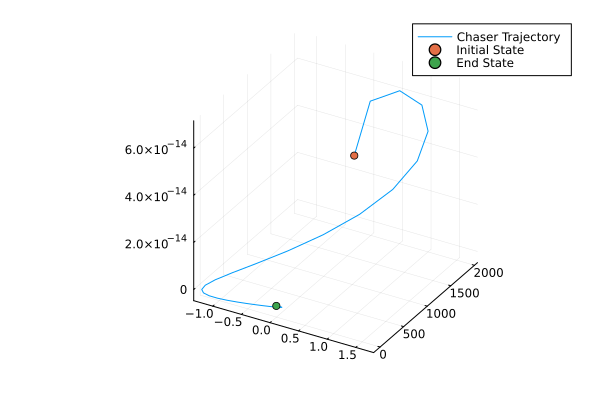

In [34]:
plot(xhist[1,:], xhist[2,:], xhist[3,:], label = "Chaser Trajectory")

scatter!([xhist[1,1]], [xhist[2,1]], [xhist[3,1]], label = "Initial State")
scatter!([xhist[1,end]], [xhist[2,end]], [xhist[3,end]], label = "End State")

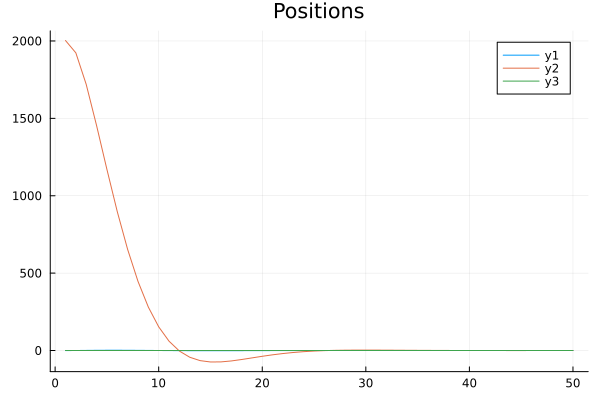

In [35]:
plot(xhist[1,:], title= "Positions")
plot!(xhist[2,:])
plot!(xhist[3,:])

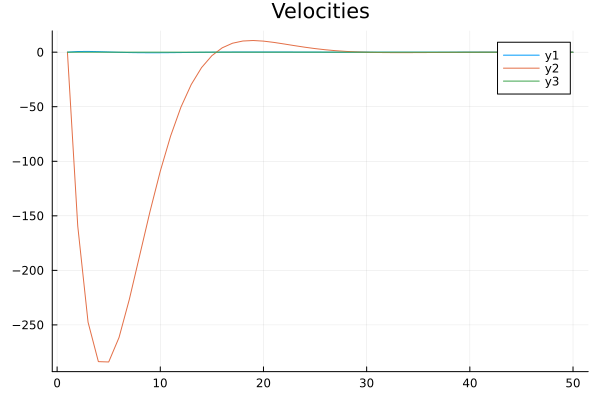

In [36]:
plot(xhist[4,:], title= "Velocities")
plot!(xhist[5,:])
plot!(xhist[6,:])

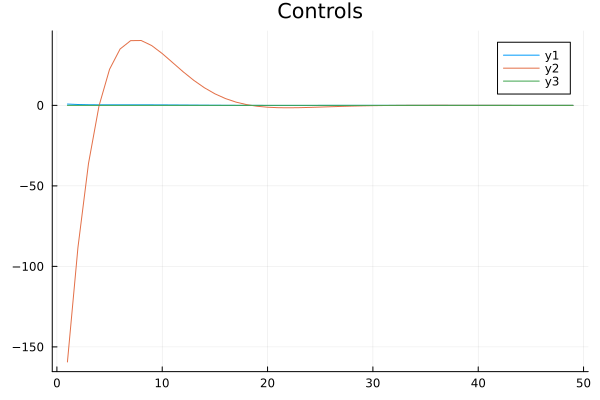

In [37]:
plot(uhist[1,:], title= "Controls")
plot!(uhist[2,:])
plot!(uhist[3,:])

In [38]:
#works well with a timestep dt =1 

#oscillates a lot when close to goal with timestep dt=60

In [ ]:
#this is because the chaser can reach the target in less than 60 seconds. and since there is no notion of low thrust, it just overshoots by alot 
#once it reaches the goal